# This colab notebook trains a classifier on the WBC-1 dataset. The weights of this model will be used later on for pretraining the WBC dataset


# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Unzipping dataset into colab instance

In [2]:
#Normal data
!unzip -q '/content/drive/MyDrive/WBC_1.zip' -d '/content/'

#On Balanced data
# !unzip -q '/content/drive/MyDrive/WBC_1_balanced.zip' -d '/content/'

# Test data
!unzip -q '/content/drive/MyDrive/WBC_test.zip' -d '/content/'

# Importing things

In [15]:
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, Subset
import os
from torchvision.datasets import ImageFolder
from torch import nn, optim
from tqdm.auto import tqdm
import torchvision.models as models
import numpy as np

# Parameters


In [16]:
class Config:
    drive_path = "/content/drive/MyDrive"
    datasets_path = f"/content/WBC_1"
    eval_path = f"/content/WBC_test"

    # Balanced
    # datasets_path = f"/content/WBC_1_balanced"

    weights_path = f"{drive_path}/weights"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_split = 0.2
    validation_split = 0.3

    learning_rate = 0.01
    weight_decay = 1e-4
    grad_clip = 0.1

    wbc_batch_size = 16
    wbc_img_resize_target = 224 # from 575 -> 224

config = Config()

# Util functions


In [17]:
# Functions for plotting graphs
def plot_model_stats(experiment, epochs, training_losses, validation_losses, training_accuracy, validation_accuracy):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Plot data on each subplot and add labels
    axes[0, 0].plot(epochs, training_losses, marker="o", color="red")
    axes[0, 0].set_title(f'{experiment}: Training Loss vs Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Training Loss')

    axes[0, 1].plot(epochs, training_accuracy, marker="o", color="green")
    axes[0, 1].set_title(f'{experiment}: Training Accuracy vs Epochs')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Training Accuracy')

    axes[1, 0].plot(epochs, validation_losses, marker="o", color="red")
    axes[1, 0].set_title(f'{experiment}: Validation Loss vs Epochs')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Validation Loss')

    axes[1, 1].plot(epochs, validation_accuracy, marker="o", color="green")
    axes[1, 1].set_title(f'{experiment}: Validation Accuracy vs Epochs')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()


# Functions needed for debugging dataset related issues

In [18]:
class LocalDebug:
    @staticmethod
    def create_mini_dataset(dataset, num_samples):
        '''
        Function to be used locally for checking if the model runs or not!

        :param dataset:
        :param num_samples:
        :return:
        '''
        subset_indices = torch.randperm(len(dataset))[:num_samples]
        subset_dataset = Subset(dataset, subset_indices)
        return subset_dataset

    @staticmethod
    def calculate_mean_and_std_of_dataset(dataset):
        '''
        Useful when determining what transforms to set

        :param dataset:
        :return:
        '''
        # dataset =  ImageFolder(root=self.path, transform=transforms.ToTensor())

        # Initialize variables to accumulate mean and standard deviation
        mean = torch.zeros(3)
        std = torch.zeros(3)

        # Loop through the dataset to compute mean and standard deviation
        for img, _ in dataset:
            mean += img.mean(1).mean(1)
            std += img.view(3, -1).std(1)

        # Calculate the mean and standard deviation
        mean /= len(dataset)
        std /= len(dataset)

        return (tuple(mean.tolist()), tuple(std.tolist()))

# Dataset wrapper to move tensors to device

In [19]:
'''
Wrapper on top of dataloader to move tensors to device
'''
class DeviceDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True, device=config.device):
        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle
        )
        self.device = device

    def __iter__(self):
        for batch in super().__iter__():
            yield self._move_to_device(batch)

    def _move_to_device(self, batch):
        if isinstance(batch, torch.Tensor):
            return batch.to(self.device)
        elif isinstance(batch, (list, tuple)):
            return [self._move_to_device(item) for item in batch]
        elif isinstance(batch, dict):
            return {key: self._move_to_device(value) for key, value in batch.items()}
        else:
            return batch



# Dataset


In [20]:
class WBCDataset:
    def __init__(self,
                 train_path,
                 eval_path,
                 take_subset=False,
                 eval_size=200,
                 val_split=config.validation_split,
                 batch_size=config.wbc_batch_size,
                 resize_to=config.wbc_img_resize_target):
        # constants
        self.train_path = train_path
        self.eval_path = eval_path
        self.batch_size = batch_size
        self.resize_to = resize_to
        self.val_split = val_split
        self.eval_size = eval_size
        self.take_subset = take_subset

        # paths
        self.train_path = os.path.join(self.train_path, "train", "data")
        self.eval_path = os.path.join(self.eval_path, "val", "data")

        # transformations
        self.transforms = transforms.Compose([
            transforms.Resize((self.resize_to, self.resize_to)),
            transforms.ToTensor()
        ])

        # create dataset
        self.train_dataset = self.get_train_dataset()
        self.test_dataset, self.validation_dataset = self.get_test_val_datasets()
        print("Datasets are initialized")

    def get_train_dataset(self):
        image_folder = ImageFolder(root=self.train_path, transform=self.transforms)

        # Uncomment for local testing
        # image_folder = LocalDebug.create_mini_dataset(image_folder, 5)

        return image_folder

    def get_test_val_datasets(self, take_subset=True):
        image_folder = ImageFolder(root=self.eval_path, transform=self.transforms)
        print("constructing test and val dataset with augmentation")

        # Calculate the number of samples to use for validation
        num_total_samples = len(image_folder)

        # find the no of train samples
        num_validation_samples = int(num_total_samples * self.val_split)
        num_test_samples = num_total_samples - num_validation_samples

        test_dataset, validation_dataset = random_split(image_folder, [num_test_samples, num_validation_samples])

        if self.take_subset:
            # find the no of train samples
            num_val_eval_samples = int(self.eval_size * self.val_split)
            num_test_eval_samples = self.eval_size - num_val_eval_samples

            test_dataset = LocalDebug.create_mini_dataset(test_dataset, num_test_eval_samples)
            validation_dataset = LocalDebug.create_mini_dataset(validation_dataset, num_val_eval_samples)

        return test_dataset, validation_dataset

    def get_dataloaders(self):
        '''

        :return: the Train, Val and test dataloaders
        '''

        # Create DataLoaders for validation and test sets
        return DeviceDataLoader(self.train_dataset, self.batch_size), \
            DeviceDataLoader(self.test_dataset, self.batch_size), \
            DeviceDataLoader(self.validation_dataset, self.batch_size)


# Generic Trainer


In [21]:
class Trainer:
    def __init__(self, name, dataset, model, save_dir, device=config.device):
        '''

        :param name: name of the experiement
        :param dataset: the dataset object which implements the method get_dataloaders()
        :param model: the model architecture used
        :param loss_criterion: the loss function used
        :param save_dir: path where the model weights can be saved
        '''
        self.name = name
        self.dataset = dataset
        self.save_dir = save_dir

        # create the directory if it doesnt exist!
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(os.path.join(self.save_dir, self.name), exist_ok=True)

        self.model = model
        self.device = device
        self.batch_size = self.dataset.batch_size

        # get loaders (each of which already moves tensors to device)
        self.train_loader, self.test_loader, self.val_loader = self.dataset.get_dataloaders()

        # Adam optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # find the most recent file and return the path
    def get_model_checkpoint_path(self, epoch_num=None):
        directory = os.path.join(self.save_dir, self.name)
        if epoch_num == None:
            # Get a list of all files in the directory
            files = os.listdir(directory)

            # Filter out only the files (exclude directories)
            files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

            # Sort the files by their modification time in descending order (most recent first)
            files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

            # Get the name of the most recently added file
            model_file = files[0] if files else None
        else:
            model_file = f"model_epoch_{epoch_num}.pt"
        return os.path.join(directory, model_file)

    # main train code
    def train(self,
              num_epochs,
              resume_epoch_num=None,
              load_from_checkpoint=False,
              epoch_saver_count=2):
        '''

        :param num_epochs:
        :param resume_epoch_num: just the name of the model checkpoint
        :param load_from_checkpoint: boolean indicating if we need to load from checkpoint or not
        :param epoch_saver_count:
        :return:
        '''
        torch.cuda.empty_cache()

        # initialize the params from the saved checkpoint
        self.init_params_from_checkpoint_hook(load_from_checkpoint, resume_epoch_num)

        # set up scheduler
        self.init_scheduler_hook(num_epochs)

        # Custom progress bar for total epochs with color and displaying average epoch loss
        total_progress_bar = tqdm(
            total=num_epochs, desc=f"Total Epochs", position=0,
            bar_format="{desc}: {percentage}% |{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]",
            dynamic_ncols=True, ncols=100, colour='red'
        )

        # Train loop
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            # Custom progress bar for each epoch with color
            epoch_progress_bar = tqdm(
                total=len(self.train_loader),
                desc=f"Epoch {epoch + 1}/{self.start_epoch + num_epochs}",
                position=1,
                leave=False,
                dynamic_ncols=True,
                ncols=100,
                colour='green'
            )

            # set model to train mode
            self.model.train()

            # set the epoch training loss
            epoch_training_loss = 0.0

            # iterate over each batch
            for batch_idx, data in enumerate(self.train_loader):
                loss = self.calculate_loss_hook(data)
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_value_(self.model.parameters(), config.grad_clip)

                self.optimizer.step()
                self.optimizer.zero_grad()

                # scheduler update
                if self.scheduler:
                    self.scheduler.step()

                # add to epoch loss
                epoch_training_loss += loss.item()

                # Update the epoch progress bar (overwrite in place)
                postfix = {
                    "loss": loss.item()
                }

                # e.g. computes things like accuracy
                batch_stats = self.calculate_train_batch_stats_hook()

                postfix.update(batch_stats)

                epoch_progress_bar.set_postfix(postfix)
                epoch_progress_bar.update(1)

            # close the epoch progress bar
            epoch_progress_bar.close()

            # calculate average epoch train statistics
            avg_train_stats = self.calculate_avg_train_stats_hook(epoch_training_loss)

            # calculate validation statistics
            avg_val_stats = self.validation_hook()

            # Store running history
            self.store_running_history_hook(epoch, avg_train_stats, avg_val_stats)

            # Show epoch stats (NOTE: Can clear the batch stats here)
            print(f"# Epoch {epoch+1}")
            epoch_postfix = self.calculate_and_print_epoch_stats_hook(avg_train_stats, avg_val_stats)


            # Update the total progress bar
            total_progress_bar.set_postfix(epoch_postfix)

            # Close tqdm bar
            total_progress_bar.update(1)

            # Save model checkpoint periodically
            need_to_save_model_checkpoint = (epoch + 1) % epoch_saver_count == 0
            if need_to_save_model_checkpoint:
                print(f"Going to save model {self.name} @ Epoch:{epoch + 1}")
                self.save_model_checkpoint_hook(epoch, avg_train_stats, avg_val_stats)

            print("-" * 60)

        # Close the total progress bar
        total_progress_bar.close()

        # Return the current state
        return self.get_current_running_history_state_hook()

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_checkpoint):
        raise NotImplementedError("Need to implement hook for initializing params from checkpoint")

    def init_scheduler_hook(self, num_epochs):
        # optimizer is already defined in the super class constructor at this point
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
        )
    def calculate_loss_hook(self, data):
        raise NotImplementedError("Need to implement hook for computing the custom loss value")

    def calculate_train_batch_stats_hook(self):
        raise NotImplementedError("Need to implement this hook for computing the batch statistics like accuracy")

    def calculate_avg_train_stats_hook(self):
        raise NotImplementedError(
            "Need to implement this hook for calculating train loss and train accuracy if applicable")

    def validation_hook(self):
        raise NotImplementedError("Need to implement this hook to calculate the validation stats")

    def calculate_and_print_epoch_stats_hook(self):
        raise NotImplementedError(
            "Need to implement this hook to calculate and print the epoch statistics and return the postfix dictinoary")

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        raise NotImplementedError("Need to implement this hook to store the running history of stats for each epoch")

    def save_model_checkpoint_hook(self, epoch, avg_train_stats, avg_val_stats):
        raise NotImplementedError("Need to implement this hook to save the model checkpoints")

    def get_current_running_history_state_hook(self):
        raise NotImplementedError("Need to implement this hook to return the history after training the model")


# Subclassing the Generic Trainer for classification tasks

In [22]:
class ClassificationTrainer(Trainer):
    def __init__(self, name, dataset, model, save_dir, num_classes):
        super().__init__(name, dataset, model, save_dir)

        # structured similarity index
        self.loss_criterion = nn.CrossEntropyLoss()

        # Values which can change based on loaded checkpoint
        self.start_epoch = 0
        self.epoch_numbers = []
        self.training_losses = []
        self.training_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []

        self.num_classes = num_classes
        self.train_correct_predictions = 0
        self.train_total_batches = 0

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_epoch_num):
        if load_from_checkpoint:
            # NOTE: resume_epoch_num can be None here if we want to load from the most recently saved checkpoint!
            checkpoint_path = self.get_model_checkpoint_path(resume_epoch_num)
            checkpoint = torch.load(checkpoint_path)

            # load previous state
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            # Things we are keeping track of
            self.start_epoch = checkpoint['epoch']
            self.epoch_numbers = checkpoint['epoch_numbers']
            self.training_losses = checkpoint['training_losses']
            self.validation_losses = checkpoint['validation_losses']
            self.training_accuracies = checkpoint['training_accuracies']
            self.validation_accuracies = checkpoint['validation_accuracies']

            print(f"Model checkpoint for {self.name} is loaded from {checkpoint_path}!")

    def calculate_train_batch_stats_hook(self):
        # Note: No accuracy to compute so leaving it as is.
        batch_stats = {
            "batch_acc": self.batch_accuracy
        }
        self.batch_accuracy = 0
        return batch_stats

    def calculate_avg_train_stats_hook(self, epoch_training_loss):
        # NOTE: no need to calculate avg training accuracy here
        avg_training_loss_for_epoch = epoch_training_loss / len(self.train_loader)
        avg_training_accuracy = self.train_correct_predictions / self.train_total_batches

        epoch_train_stats = {
            "avg_training_loss": avg_training_loss_for_epoch,
            "avg_training_accuracy": avg_training_accuracy
        }

        # reset
        self.train_correct_predictions = 0
        self.train_total_batches = 0

        return epoch_train_stats

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        self.epoch_numbers.append(epoch + 1)
        self.training_losses.append(avg_train_stats["avg_training_loss"])
        self.training_accuracies.append(avg_train_stats["avg_training_accuracy"])

        self.validation_losses.append(avg_val_stats["avg_val_loss_for_epoch"])
        self.validation_accuracies.append(avg_val_stats["avg_val_accuracy"])

    def calculate_and_print_epoch_stats_hook(self, avg_train_stats, avg_val_stats):
        print(
            f"Epoch loss: {avg_train_stats['avg_training_loss']} | Train Acc: {avg_train_stats['avg_training_accuracy']} | Val Acc: {avg_val_stats['avg_val_accuracy']} | Val loss: {avg_val_stats['avg_val_loss_for_epoch']}")

        return {
            "epoch_loss": avg_train_stats['avg_training_loss'],
            "val_loss": avg_val_stats['avg_val_loss_for_epoch'],
            "train_acc": avg_train_stats['avg_training_accuracy'],
            "val_acc": avg_val_stats['avg_val_accuracy']
        }

    def save_model_checkpoint_hook(self, epoch, avg_train_stats, avg_val_stats):
        # set it to train mode to save the weights (but doesn't matter apparently!)
        self.model.train()

        # create the directory if it doesn't exist
        model_save_directory = os.path.join(self.save_dir, self.name)
        os.makedirs(model_save_directory, exist_ok=True)

        # Checkpoint the model at the end of each epoch
        checkpoint_path = os.path.join(model_save_directory, f'model_epoch_{epoch + 1}.pt')
        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'epoch': epoch + 1,
                'epoch_numbers': self.epoch_numbers,
                'training_losses': self.training_losses,
                'training_accuracies': self.training_accuracies,
                'validation_losses': self.validation_losses,
                'validation_accuracies': self.validation_accuracies
            },
            checkpoint_path
        )
        print(f"Saved the model checkpoint for experiment {self.name} for epoch {epoch + 1}")

    def get_current_running_history_state_hook(self):
        return self.epoch_numbers, self.training_losses, self.training_accuracies, self.validation_losses, self.validation_accuracies

    # util code
    def one_hot(self, labels):
        # Create an empty one-hot tensor
        one_hot_tensor = torch.zeros((labels.size(0), self.num_classes), dtype=torch.float32).to(config.device)

        # Use scatter to fill in the one-hot tensor
        one_hot_tensor.scatter_(1, labels.view(-1, 1), 1)

        return one_hot_tensor

# WBC Trainer

In [23]:
class WBCClassifierTrainer(ClassificationTrainer):
    def __init__(self, name, dataset, model, save_dir, num_classes=5):
        super().__init__(name, dataset, model, save_dir, num_classes)

    # hooks
    def calculate_loss_hook(self, data):
        images, labels = data
        one_hot_labels = self.one_hot(labels)
        output_logits = self.model(images)
        loss = self.loss_criterion(output_logits, one_hot_labels)

        # compute the batch stats right here and save it
        output_probs = nn.Softmax(dim=1)(output_logits)
        predicted = torch.argmax(output_probs, 1)
        batch_correct_predictions = (predicted == labels).sum().item()
        batch_size = labels.size(0)

        # store the accuracies
        self.batch_accuracy = batch_correct_predictions / batch_size
        self.train_correct_predictions += batch_correct_predictions
        self.train_total_batches += labels.size(0)

        return loss

    def validation_hook(self):
        '''
        :return: avg val loss for that epoch
        '''
        val_loss = 0.0
        val_correct_predictions = 0
        total_val_samples = 0

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for val_batch_idx, val_data in enumerate(self.val_loader):
                val_images, val_labels = val_data
                one_hot_val_labels = self.one_hot(val_labels)

                val_logits = self.model(val_images)

                val_loss += self.loss_criterion(val_logits, one_hot_val_labels).item()

                # Compute validation accuracy for this batch
                val_probs = nn.Softmax(dim=1)(val_logits)
                val_predicted = torch.argmax(val_probs, dim=1)
                total_val_samples += val_labels.size(0)
                val_correct_predictions += (val_predicted == val_labels).sum().item()

        # Calculate average validation loss for the epoch
        avg_val_loss_for_epoch = val_loss / len(self.val_loader)

        # Calculate validation accuracy for the epoch
        avg_val_accuracy = val_correct_predictions / total_val_samples

        return {
            "avg_val_loss_for_epoch": avg_val_loss_for_epoch,
            "avg_val_accuracy": avg_val_accuracy
        }

    def test_model(self):
        test_loss = 0.0
        test_correct_predictions = 0
        total_test_samples = 0

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for test_batch_idx, test_data in enumerate(self.test_loader):
                test_images, test_labels = test_data
                one_hot_test_labels = self.one_hot(test_labels)

                test_logits = self.model(test_images)

                test_loss += self.loss_criterion(test_logits, one_hot_test_labels).item()

                # Compute validation accuracy for this batch
                test_probs = nn.Softmax(dim=1)(test_logits)
                test_predicted = torch.argmax(test_probs, dim=1)
                total_test_samples += test_labels.size(0)
                test_correct_predictions += (test_predicted == test_labels).sum().item()

        # Calculate average validation loss for the epoch
        avg_test_loss = test_loss / len(self.test_loader)

        # Calculate validation accuracy for the epoch
        avg_test_accuracy = test_correct_predictions / total_test_samples

        return {
            "test_loss": avg_test_loss,
            "test_accuracy": avg_test_accuracy
        }

# Model


In [24]:
class WBCClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.num_classes = num_classes

        self.conv1 = self.conv_and_batch_norm_block(3, 64)
        self.conv2 = self.conv_and_batch_norm_block(64, 128, pool=True)
        self.res1 = self.conv_and_batch_norm_block(128, 128)
        self.res2 = self.conv_and_batch_norm_block(128, 128)

        self.conv3 = self.conv_and_batch_norm_block(128, 256, pool=True)
        self.conv4 = self.conv_and_batch_norm_block(256, 512, pool=True)

        self.res3 = self.conv_and_batch_norm_block(512, 512)
        self.res4 = self.conv_and_batch_norm_block(512, 512)

        #new approach with only resnet18
        # Replace the initial layers with a pre-trained ResNet-18 backbone
        self.resnet18 = models.resnet18(pretrained=True).to(config.device)

        # set to non trainable
        self.resnet18.eval()
        for param in self.resnet18.parameters():
            param.requires_grad = False

        # remove the fully connected layer
        self.resnet18.fc = nn.Identity().to(config.device)  # Remove the fully connected layer (classifier)

        self.classifier = nn.Sequential(
            nn.Linear(512, 128),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 32),  # Adjust input size based on the output of ResNet-18
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, self.num_classes)
        ).to(config.device)

    def conv_and_batch_norm_block(self, in_channels, out_channels, pool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Pass input through the ResNet-18 backbone
        features = self.resnet18(x)

        # Continue with the linear stack and predictor
        classified = self.classifier(features)
        return classified

    def old_forward(self, x):
        out = self.conv1(x)  # shape (b,64,512,512)
        out1 = self.conv2(out)  # shape (b,128,256,256)
        out = self.res1(out1) + out1  # skip connections, shape (b,128,256,256)
        out = out1 + self.res2(out) + out  # multi skip connections, shape (b,128,256,256)
        out = self.conv3(out)  # shape is (b,256,128,128)
        out2 = self.conv4(out)  # shape is (b,512,64,64)
        out = self.res3(out2) + out2  # skip connections, shape is (b,512,64,64)
        out = out2 + self.res4(out) + out  # multi skip connections, shape is (b,512,64,64)
        out = self.classifier(out)
        return out

# Creating the dataset

In [25]:
path = os.path.abspath(config.datasets_path)
eval_path = os.path.abspath(config.eval_path)
wbc_dataset = WBCDataset(path, eval_path)

constructing test and val dataset with augmentation
Datasets are initialized


# Training code

In [26]:
name = "wbc_1_base"
model = WBCClassifier().to(config.device)
save_dir = os.path.abspath(config.weights_path)
wbc_trainer = WBCClassifierTrainer(name, wbc_dataset, model, save_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 20.3MB/s]


In [27]:
epoch_numbers, training_losses, training_accuracies, validation_losses, validation_accuracies = wbc_trainer.train(44 ,epoch_saver_count=2)

Total Epochs: 0.0% |          | 0/44 [00:00<?, ?it/s]

Epoch 1/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 1
Epoch loss: 1.5804293354352315 | Train Acc: 0.6179775280898876 | Val Acc: 0.6467181467181468 | Val loss: 1.5550308913895579
------------------------------------------------------------


Epoch 2/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 2
Epoch loss: 1.5247881611188252 | Train Acc: 0.6292134831460674 | Val Acc: 0.6467181467181468 | Val loss: 1.4794452840631658
Going to save model wbc_1_base @ Epoch:2
Saved the model checkpoint for experiment wbc_1_base for epoch 2
------------------------------------------------------------


Epoch 3/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 3
Epoch loss: 1.4051285982131958 | Train Acc: 0.6292134831460674 | Val Acc: 0.6467181467181468 | Val loss: 1.178841921416196
------------------------------------------------------------


Epoch 4/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 4
Epoch loss: 1.1017109751701355 | Train Acc: 0.6179775280898876 | Val Acc: 0.6467181467181468 | Val loss: 1.1809987127780914
Going to save model wbc_1_base @ Epoch:4
Saved the model checkpoint for experiment wbc_1_base for epoch 4
------------------------------------------------------------


Epoch 5/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 5
Epoch loss: 1.1778961618741353 | Train Acc: 0.6404494382022472 | Val Acc: 0.6467181467181468 | Val loss: 1.099471856247295
------------------------------------------------------------


Epoch 6/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 6
Epoch loss: 1.1297651529312134 | Train Acc: 0.5168539325842697 | Val Acc: 0.6467181467181468 | Val loss: 1.0552199645475908
Going to save model wbc_1_base @ Epoch:6
Saved the model checkpoint for experiment wbc_1_base for epoch 6
------------------------------------------------------------


Epoch 7/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 7
Epoch loss: 1.0341365436712902 | Train Acc: 0.6292134831460674 | Val Acc: 0.6467181467181468 | Val loss: 1.008607763232607
------------------------------------------------------------


Epoch 8/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 8
Epoch loss: 1.017620027065277 | Train Acc: 0.6292134831460674 | Val Acc: 0.6467181467181468 | Val loss: 1.0075900157292683
Going to save model wbc_1_base @ Epoch:8
Saved the model checkpoint for experiment wbc_1_base for epoch 8
------------------------------------------------------------


Epoch 9/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 9
Epoch loss: 0.9960717956225077 | Train Acc: 0.6292134831460674 | Val Acc: 0.6467181467181468 | Val loss: 1.113618740529725
------------------------------------------------------------


Epoch 10/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 10
Epoch loss: 1.111763834953308 | Train Acc: 0.6292134831460674 | Val Acc: 0.6467181467181468 | Val loss: 0.9234872370055227
Going to save model wbc_1_base @ Epoch:10
Saved the model checkpoint for experiment wbc_1_base for epoch 10
------------------------------------------------------------


Epoch 11/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 11
Epoch loss: 0.9444965720176697 | Train Acc: 0.6292134831460674 | Val Acc: 0.6467181467181468 | Val loss: 1.268623664523616
------------------------------------------------------------


Epoch 12/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 12
Epoch loss: 0.8602853616078695 | Train Acc: 0.6292134831460674 | Val Acc: 0.6467181467181468 | Val loss: 0.9153165194121274
Going to save model wbc_1_base @ Epoch:12
Saved the model checkpoint for experiment wbc_1_base for epoch 12
------------------------------------------------------------


Epoch 13/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 13
Epoch loss: 0.7783301124970118 | Train Acc: 0.6292134831460674 | Val Acc: 0.6853281853281853 | Val loss: 0.8017644340341742
------------------------------------------------------------


Epoch 14/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 14
Epoch loss: 0.6746108333269755 | Train Acc: 0.7078651685393258 | Val Acc: 0.6467181467181468 | Val loss: 0.8540386232462797
Going to save model wbc_1_base @ Epoch:14
Saved the model checkpoint for experiment wbc_1_base for epoch 14
------------------------------------------------------------


Epoch 15/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 15
Epoch loss: 0.7403480609258016 | Train Acc: 0.651685393258427 | Val Acc: 0.7355212355212355 | Val loss: 0.7678665545853701
------------------------------------------------------------


Epoch 16/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 16
Epoch loss: 0.794406846165657 | Train Acc: 0.7865168539325843 | Val Acc: 0.6872586872586872 | Val loss: 0.828985953872854
Going to save model wbc_1_base @ Epoch:16
Saved the model checkpoint for experiment wbc_1_base for epoch 16
------------------------------------------------------------


Epoch 17/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 17
Epoch loss: 0.8396492302417755 | Train Acc: 0.6629213483146067 | Val Acc: 0.6621621621621622 | Val loss: 0.8668403146844922
------------------------------------------------------------


Epoch 18/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 18
Epoch loss: 0.9220146884520849 | Train Acc: 0.797752808988764 | Val Acc: 0.6872586872586872 | Val loss: 1.1677194766022942
Going to save model wbc_1_base @ Epoch:18
Saved the model checkpoint for experiment wbc_1_base for epoch 18
------------------------------------------------------------


Epoch 19/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 19
Epoch loss: 0.7613038122653961 | Train Acc: 0.7752808988764045 | Val Acc: 0.7239382239382239 | Val loss: 0.7732872384967227
------------------------------------------------------------


Epoch 20/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 20
Epoch loss: 0.5393490592638651 | Train Acc: 0.8089887640449438 | Val Acc: 0.7142857142857143 | Val loss: 1.3790690506046468
Going to save model wbc_1_base @ Epoch:20
Saved the model checkpoint for experiment wbc_1_base for epoch 20
------------------------------------------------------------


Epoch 21/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 21
Epoch loss: 0.9124039908250173 | Train Acc: 0.7752808988764045 | Val Acc: 0.6254826254826255 | Val loss: 1.250847527475068
------------------------------------------------------------


Epoch 22/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 22
Epoch loss: 0.6474736904104551 | Train Acc: 0.8202247191011236 | Val Acc: 0.7335907335907336 | Val loss: 0.7864361954006281
Going to save model wbc_1_base @ Epoch:22
Saved the model checkpoint for experiment wbc_1_base for epoch 22
------------------------------------------------------------


Epoch 23/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 23
Epoch loss: 0.46392153203487396 | Train Acc: 0.8314606741573034 | Val Acc: 0.7548262548262549 | Val loss: 0.7789541419708368
------------------------------------------------------------


Epoch 24/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 24
Epoch loss: 0.5106711486975352 | Train Acc: 0.8202247191011236 | Val Acc: 0.7586872586872587 | Val loss: 0.7248541924989584
Going to save model wbc_1_base @ Epoch:24
Saved the model checkpoint for experiment wbc_1_base for epoch 24
------------------------------------------------------------


Epoch 25/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 25
Epoch loss: 0.5199031680822372 | Train Acc: 0.8314606741573034 | Val Acc: 0.750965250965251 | Val loss: 0.7382291645714731
------------------------------------------------------------


Epoch 26/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 26
Epoch loss: 0.5676507527629534 | Train Acc: 0.8202247191011236 | Val Acc: 0.747104247104247 | Val loss: 0.7843343886462125
Going to save model wbc_1_base @ Epoch:26
Saved the model checkpoint for experiment wbc_1_base for epoch 26
------------------------------------------------------------


Epoch 27/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 27
Epoch loss: 0.445583571990331 | Train Acc: 0.8202247191011236 | Val Acc: 0.7644787644787645 | Val loss: 0.7469189501169956
------------------------------------------------------------


Epoch 28/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 28
Epoch loss: 0.7012974619865417 | Train Acc: 0.7528089887640449 | Val Acc: 0.752895752895753 | Val loss: 0.7965010144945347
Going to save model wbc_1_base @ Epoch:28
Saved the model checkpoint for experiment wbc_1_base for epoch 28
------------------------------------------------------------


Epoch 29/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 29
Epoch loss: 0.2814430333673954 | Train Acc: 0.8651685393258427 | Val Acc: 0.7683397683397684 | Val loss: 0.7943941201224471
------------------------------------------------------------


Epoch 30/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 30
Epoch loss: 0.33593595524628955 | Train Acc: 0.8651685393258427 | Val Acc: 0.7567567567567568 | Val loss: 0.9755287353288044
Going to save model wbc_1_base @ Epoch:30
Saved the model checkpoint for experiment wbc_1_base for epoch 30
------------------------------------------------------------


Epoch 31/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 31
Epoch loss: 0.35932143156727153 | Train Acc: 0.8539325842696629 | Val Acc: 0.7548262548262549 | Val loss: 0.9480368965728716
------------------------------------------------------------


Epoch 32/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 32
Epoch loss: 0.3101527119676272 | Train Acc: 0.8764044943820225 | Val Acc: 0.7606177606177607 | Val loss: 0.8668544707876263
Going to save model wbc_1_base @ Epoch:32
Saved the model checkpoint for experiment wbc_1_base for epoch 32
------------------------------------------------------------


Epoch 33/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 33
Epoch loss: 0.32984806473056477 | Train Acc: 0.898876404494382 | Val Acc: 0.7625482625482626 | Val loss: 0.8546227092544237
------------------------------------------------------------


Epoch 34/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 34
Epoch loss: 0.3713182061910629 | Train Acc: 0.8764044943820225 | Val Acc: 0.777992277992278 | Val loss: 0.8264335874806751
Going to save model wbc_1_base @ Epoch:34
Saved the model checkpoint for experiment wbc_1_base for epoch 34
------------------------------------------------------------


Epoch 35/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 35
Epoch loss: 0.36741840839385986 | Train Acc: 0.8876404494382022 | Val Acc: 0.7683397683397684 | Val loss: 0.8041017078088991
------------------------------------------------------------


Epoch 36/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 36
Epoch loss: 0.34237953275442123 | Train Acc: 0.9213483146067416 | Val Acc: 0.7567567567567568 | Val loss: 0.895297216646599
Going to save model wbc_1_base @ Epoch:36
Saved the model checkpoint for experiment wbc_1_base for epoch 36
------------------------------------------------------------


Epoch 37/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 37
Epoch loss: 0.2810412918527921 | Train Acc: 0.9101123595505618 | Val Acc: 0.7625482625482626 | Val loss: 0.9288213749726614
------------------------------------------------------------


Epoch 38/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 38
Epoch loss: 0.2581311985850334 | Train Acc: 0.8764044943820225 | Val Acc: 0.7625482625482626 | Val loss: 0.982366438842181
Going to save model wbc_1_base @ Epoch:38
Saved the model checkpoint for experiment wbc_1_base for epoch 38
------------------------------------------------------------


Epoch 39/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 39
Epoch loss: 0.21294945144715408 | Train Acc: 0.9325842696629213 | Val Acc: 0.7586872586872587 | Val loss: 0.9685621365453257
------------------------------------------------------------


Epoch 40/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 40
Epoch loss: 0.2555503124992053 | Train Acc: 0.898876404494382 | Val Acc: 0.7586872586872587 | Val loss: 0.9605318730076154
Going to save model wbc_1_base @ Epoch:40
Saved the model checkpoint for experiment wbc_1_base for epoch 40
------------------------------------------------------------


Epoch 41/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 41
Epoch loss: 0.32028548667828244 | Train Acc: 0.9101123595505618 | Val Acc: 0.7760617760617761 | Val loss: 0.9027008188493324
------------------------------------------------------------


Epoch 42/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 42
Epoch loss: 0.29922300825516385 | Train Acc: 0.8764044943820225 | Val Acc: 0.7702702702702703 | Val loss: 0.8925931846553629
Going to save model wbc_1_base @ Epoch:42
Saved the model checkpoint for experiment wbc_1_base for epoch 42
------------------------------------------------------------


Epoch 43/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 43
Epoch loss: 0.24910981332262358 | Train Acc: 0.9325842696629213 | Val Acc: 0.7702702702702703 | Val loss: 0.9347929773908673
------------------------------------------------------------


Epoch 44/44:   0%|          | 0/6 [00:00<?, ?it/s]

# Epoch 44
Epoch loss: 0.3319571961959203 | Train Acc: 0.8764044943820225 | Val Acc: 0.7683397683397684 | Val loss: 0.9429486260721178
Going to save model wbc_1_base @ Epoch:44
Saved the model checkpoint for experiment wbc_1_base for epoch 44
------------------------------------------------------------


## Training for more epochs if required

In [28]:
# epoch_numbers, training_losses, training_accuracies, validation_losses, validation_accuracies = wbc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

# Testing the model

In [29]:
test_stats = wbc_trainer.test_model()

In [30]:
test_stats

{'test_loss': 1.1338890216460353, 'test_accuracy': 0.7371900826446282}

# Plotting the graphs

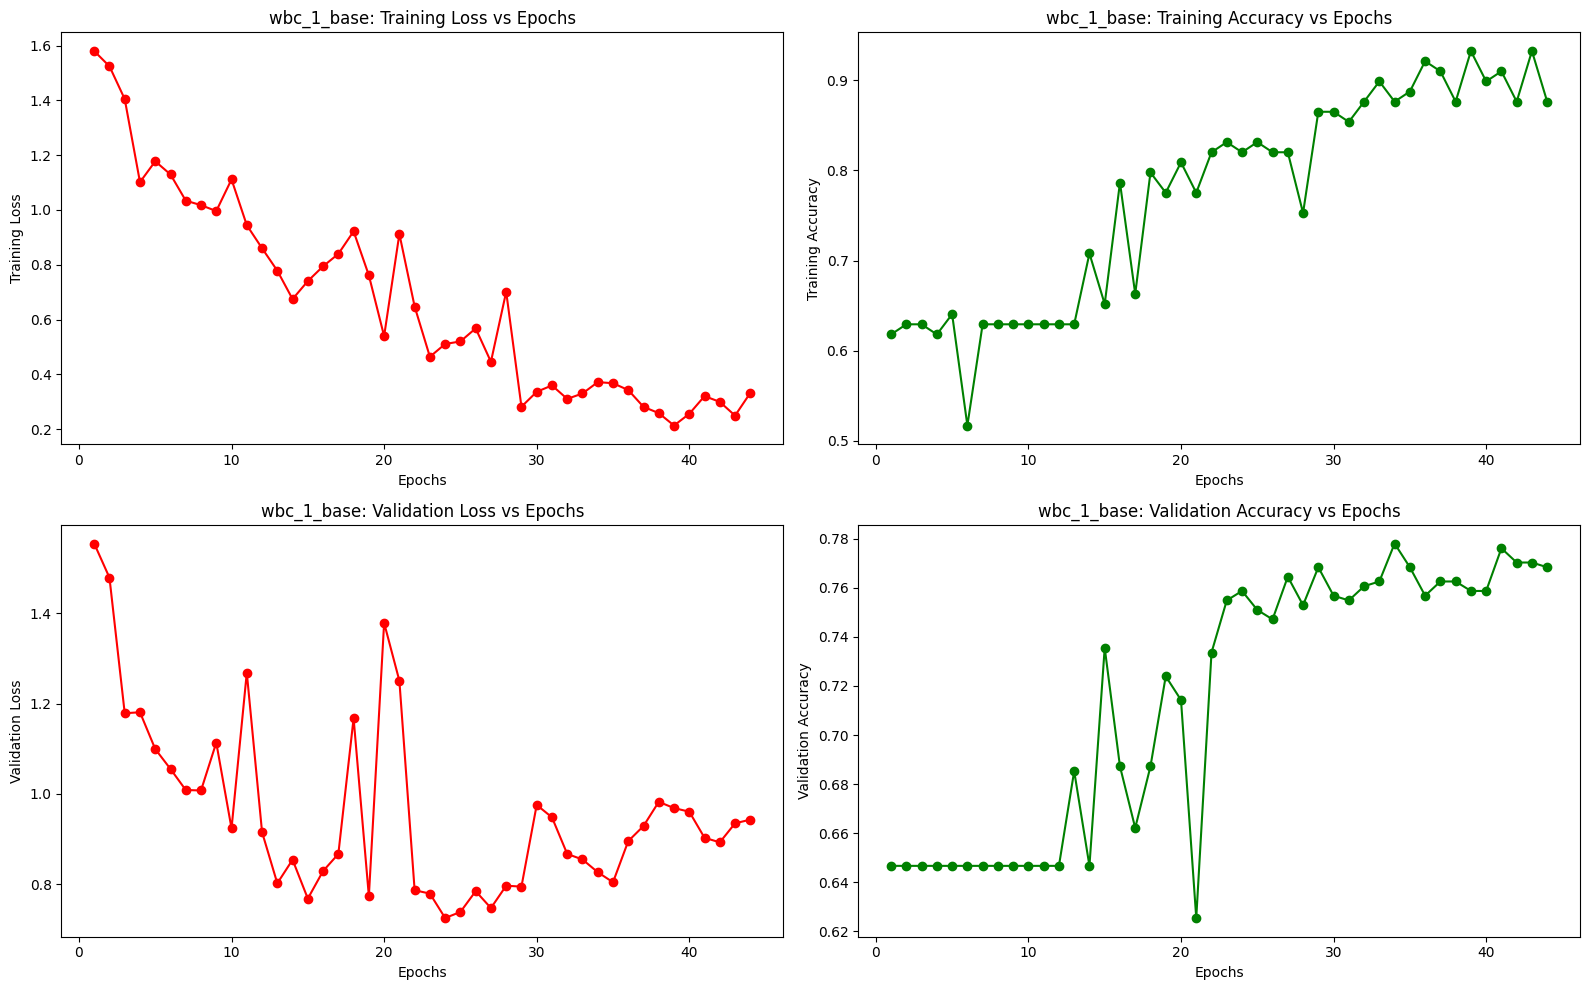

In [31]:
plot_model_stats(name, epoch_numbers, training_losses, validation_losses, training_accuracies, validation_accuracies)